# Studying the Damped Harmonic Oscillator with Physics Informed Neural Networks

## Setup

In [102]:
%reset -f

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from tqdm.notebook import tqdm
import torch
# import torch.nn as nn
# import torch.optim as optim


In [104]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU is available")
else:
    device = torch.device('cpu')
    print("GPU is not available, using CPU")

GPU is available


In [105]:
seed = 0

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## The Damped Armonic Oscillator

In [106]:
# model parameters

m = 1    # mass
d = 0.1   # damping coefficient
k = 1    # spring constant

# ODE
def damped_oscillator_ode(y, t, m, d, k):
    x, v  = y
    dydt = [ v, - v*d/m - k*x ]
    return dydt

In [107]:
# initial conditions
x_0 = 0   #initial position
v_0 = 1   #initial velocity

y_0 = [x_0 , v_0]

# time
t = np.linspace(0, 50, 510, dtype=np.float32)

In [108]:
#solution
sol = odeint(damped_oscillator_ode, y_0, t, args=(m, d, k))

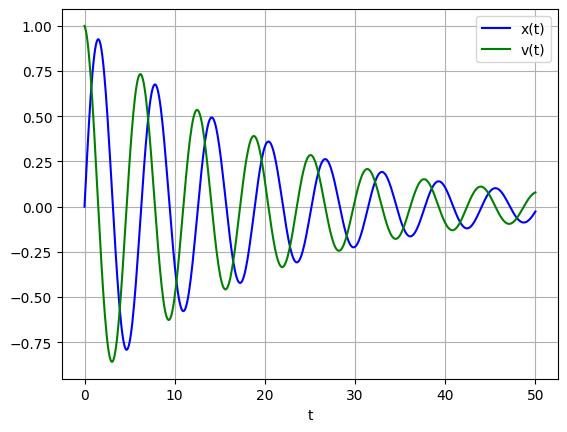

In [109]:
plt.plot(t, sol[:, 0], 'b', label='x(t)')
plt.plot(t, sol[:, 1], 'g', label='v(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

## Training Data Creation

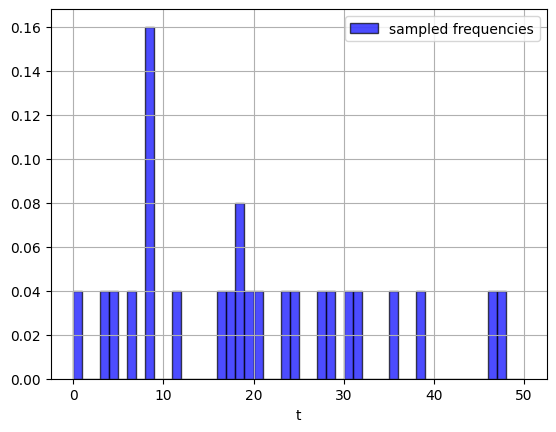

In [110]:
# Training Data
time_tensor = torch.from_numpy(t).to(torch.float32).reshape(-1, 1)
sol_tensor = torch.from_numpy(sol).to(torch.float32)


indices = np.random.randint(0, 510, int(510 * 0.05))
indices = np.sort(indices)
data = time_tensor[indices,:]
labels = sol_tensor[indices,:]

differential_operator = torch.tensor([[0.0, 1.0], [-d/m, -k/m]], dtype=torch.float32)
target_grads =  labels @ differential_operator.T

# show sampled points
plt.hist(data.cpu().detach().numpy(), bins=50, range=(0, 50), density=True, label='sampled frequencies', alpha=0.7, color='blue', edgecolor='black')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()



## Classic Supervised Learning Approach

In [111]:
class NetworkArchitecture(torch.nn.Module):
    def __init__(self):
        super(NetworkArchitecture, self).__init__()
        self.fc1 = torch.nn.Linear(1, 16)  # Input layer to hidden layer
        self.fc2 = torch.nn.Linear(16, 32) # Upsampling 1
        self.fc3 = torch.nn.Linear(32, 64) # Upsampling 2
        self.fc4 = torch.nn.Linear(64, 64) # Middle layer
        self.fc5 = torch.nn.Linear(64, 32) # Downsampling 1
        self.fc6 = torch.nn.Linear(32, 2)  # Hidden layer to output layer


        #self.act =  torch.nn.LeakyReLU(negative_slope=0.1)
        self.act =  torch.nn.Tanh()


    def forward(self, x):
        x = self.act(self.fc1(x))  # Activation function
        x = self.act(self.fc2(x))  # Activation function
        x = self.act(self.fc3(x))  # Activation function
        x = self.act(self.fc4(x))  # Activation function
        x = self.act(self.fc4(x))  # Activation function
        x = self.act(self.fc5(x))  # Activation function
        x = self.fc6(x)          # No activation for the output layer (regression)
        return x

In [112]:
# Initialize the model, loss function, and optimizer
model = NetworkArchitecture()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [113]:
num_epochs = 20000
data.requires_grad_(True)
model = model.to(device)
data = data.to(device)
labels = labels.to(device)

best_loss = float('inf')

for epoch in tqdm(range(num_epochs)):
    # Setup Training Step
    model.train()
    optimizer.zero_grad()

    # Forward pass
    predictions = model(data)

    #Compute Gradients
    grads0 = torch.autograd.grad(
      outputs = predictions[:,0],
      inputs = data,
      grad_outputs = torch.ones_like(predictions[:,0]),
      create_graph=False,
      retain_graph=True
    )[0]

    # Compute loss
    loss = criterion(predictions, labels)

    #Store Best Model
    if loss < best_loss:
      best_loss = loss
      best_model_state_dict = model.state_dict()
      nn_grads = grads0.cpu().detach().numpy()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    if (epoch+1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {best_loss.item():.4f}')

  0%|          | 0/20000 [00:00<?, ?it/s]

Epoch [1000/20000], Loss: 0.0573
Epoch [2000/20000], Loss: 0.0242
Epoch [3000/20000], Loss: 0.0173
Epoch [4000/20000], Loss: 0.0173
Epoch [5000/20000], Loss: 0.0116
Epoch [6000/20000], Loss: 0.0075
Epoch [7000/20000], Loss: 0.0057
Epoch [8000/20000], Loss: 0.0015
Epoch [9000/20000], Loss: 0.0015
Epoch [10000/20000], Loss: 0.0015
Epoch [11000/20000], Loss: 0.0015
Epoch [12000/20000], Loss: 0.0013
Epoch [13000/20000], Loss: 0.0002
Epoch [14000/20000], Loss: 0.0001
Epoch [15000/20000], Loss: 0.0001
Epoch [16000/20000], Loss: 0.0001
Epoch [17000/20000], Loss: 0.0000
Epoch [18000/20000], Loss: 0.0000
Epoch [19000/20000], Loss: 0.0000
Epoch [20000/20000], Loss: 0.0000


In [114]:
# Save test data for plotting
model.load_state_dict(best_model_state_dict)
model = model.to(device)

test_input = time_tensor
test_output = model(test_input.to(device))
nn_sol = test_output.cpu().detach().numpy()




## Pure PINN approach

In [115]:
# Initialize the model, loss function, and optimizer
model_pinn = NetworkArchitecture() #borrow the architecture from the classical approach
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_pinn.parameters(), lr=0.001)

# Training loop
num_epochs = 20000
data.requires_grad_(True)
model_pinn = model_pinn.to(device)
data = data.to(device)
labels = labels.to(device)
target_grads = target_grads.to(device)

best_loss = float('inf')

for epoch in tqdm(range(num_epochs)):

    # Setup Training Step
    model_pinn.train()
    optimizer.zero_grad()

    # Forward pass
    predictions = model_pinn(data)

    # Compute gradients
    grads0 = torch.autograd.grad(
      outputs = predictions[:,0],
      inputs = data,
      grad_outputs = torch.ones_like(predictions[:,0]),
      create_graph=True,
      retain_graph=True
    )[0]

    grads1 = torch.autograd.grad(
      outputs = predictions[:,1],
      inputs = data,
      grad_outputs = torch.ones_like(predictions[:,1]),
      create_graph=True,
      retain_graph=True
    )[0]

    grads = torch.cat((grads0, grads1), dim=1).to(device)


    # Compute Loss
    pinn_loss = criterion(grads, target_grads) + (predictions[0,0] - x_0)**2 + (predictions[0,1]-v_0)**2

    #Store Best Model
    if pinn_loss < best_loss:
      best_loss = pinn_loss
      best_model_pinn_state_dict = model_pinn.state_dict()
      nn_grads_pinn = grads0.cpu().detach().numpy()

    # Backward pass
    pinn_loss.backward()

    #Update weights
    optimizer.step()

    #Print Loss once in a while
    if (epoch+1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {best_loss.item():.4f}')


  0%|          | 0/20000 [00:00<?, ?it/s]

Epoch [1000/20000], Loss: 0.0757
Epoch [2000/20000], Loss: 0.0308
Epoch [3000/20000], Loss: 0.0152
Epoch [4000/20000], Loss: 0.0014
Epoch [5000/20000], Loss: 0.0009
Epoch [6000/20000], Loss: 0.0008
Epoch [7000/20000], Loss: 0.0007
Epoch [8000/20000], Loss: 0.0006
Epoch [9000/20000], Loss: 0.0003
Epoch [10000/20000], Loss: 0.0000
Epoch [11000/20000], Loss: 0.0000
Epoch [12000/20000], Loss: 0.0000
Epoch [13000/20000], Loss: 0.0000
Epoch [14000/20000], Loss: 0.0000
Epoch [15000/20000], Loss: 0.0000
Epoch [16000/20000], Loss: 0.0000
Epoch [17000/20000], Loss: 0.0000
Epoch [18000/20000], Loss: 0.0000
Epoch [19000/20000], Loss: 0.0000
Epoch [20000/20000], Loss: 0.0000


In [116]:
# Save testing data for plotting
model_pinn.load_state_dict(best_model_pinn_state_dict)
model_pinn = model_pinn.to(device)

test_input_pinn = time_tensor
test_output_pinn = model_pinn(test_input.to(device))
nn_sol_pinn = test_output_pinn.cpu().detach().numpy()

## Hybrid Approach

In [117]:
# Initialize the model, loss function, and optimizer
model_hyb = NetworkArchitecture() #borrow the architecture from the classical approach
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_hyb.parameters(), lr=0.001)
l_d, l_iv, l_c = 1, 1, 1

# Training loop
num_epochs = 20000
data.requires_grad_(True)
model_hyb = model_hyb.to(device)
data = data.to(device)
labels = labels.to(device)
target_grads = target_grads.to(device)

best_loss = float('inf')

for epoch in tqdm(range(num_epochs)):

    # Setup Training Step
    model_hyb.train()
    optimizer.zero_grad()

    # Forward pass
    predictions = model_hyb(data)

    # Compute gradients
    grads0 = torch.autograd.grad(
      outputs = predictions[:,0],
      inputs = data,
      grad_outputs = torch.ones_like(predictions[:,0]),
      create_graph=True,
      retain_graph=True
    )[0]

    grads1 = torch.autograd.grad(
      outputs = predictions[:,1],
      inputs = data,
      grad_outputs = torch.ones_like(predictions[:,1]),
      create_graph=True,
      retain_graph=True
    )[0]

    grads = torch.cat((grads0, grads1), dim=1).to(device)


    # Compute Loss
    loss_differential = criterion(grads, target_grads)
    loss_iv = (predictions[0,0] - x_0)**2 + (predictions[0,1]-v_0)**2
    loss_classic = criterion(predictions, labels)

    hyb_loss = loss_differential * l_d + loss_iv * l_iv + loss_classic * l_c

    #Store Best Model
    if hyb_loss < best_loss:
      best_loss = hyb_loss
      best_model_hyb_state_dict = model_hyb.state_dict()
      nn_grads_hyb = grads0.cpu().detach().numpy()


    # Backward pass
    hyb_loss.backward()

    #Update weights
    optimizer.step()

    #Print Loss once in a while
    if (epoch+1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {best_loss.item():.4f}')


  0%|          | 0/20000 [00:00<?, ?it/s]

Epoch [1000/20000], Loss: 0.1277
Epoch [2000/20000], Loss: 0.0744
Epoch [3000/20000], Loss: 0.0689
Epoch [4000/20000], Loss: 0.0672
Epoch [5000/20000], Loss: 0.0663
Epoch [6000/20000], Loss: 0.0660
Epoch [7000/20000], Loss: 0.0654
Epoch [8000/20000], Loss: 0.0596
Epoch [9000/20000], Loss: 0.0355
Epoch [10000/20000], Loss: 0.0330
Epoch [11000/20000], Loss: 0.0286
Epoch [12000/20000], Loss: 0.0229
Epoch [13000/20000], Loss: 0.0191
Epoch [14000/20000], Loss: 0.0181
Epoch [15000/20000], Loss: 0.0169
Epoch [16000/20000], Loss: 0.0162
Epoch [17000/20000], Loss: 0.0160
Epoch [18000/20000], Loss: 0.0158
Epoch [19000/20000], Loss: 0.0155
Epoch [20000/20000], Loss: 0.0153


In [118]:
# Save testing data for plotting
model_hyb.load_state_dict(best_model_hyb_state_dict)
model_hyb = model_hyb.to(device)

test_input_hyb = time_tensor
test_output_hyb = model_hyb(test_input_hyb.to(device))
nn_sol_hyb = test_output_hyb.cpu().detach().numpy()

## Comparisons

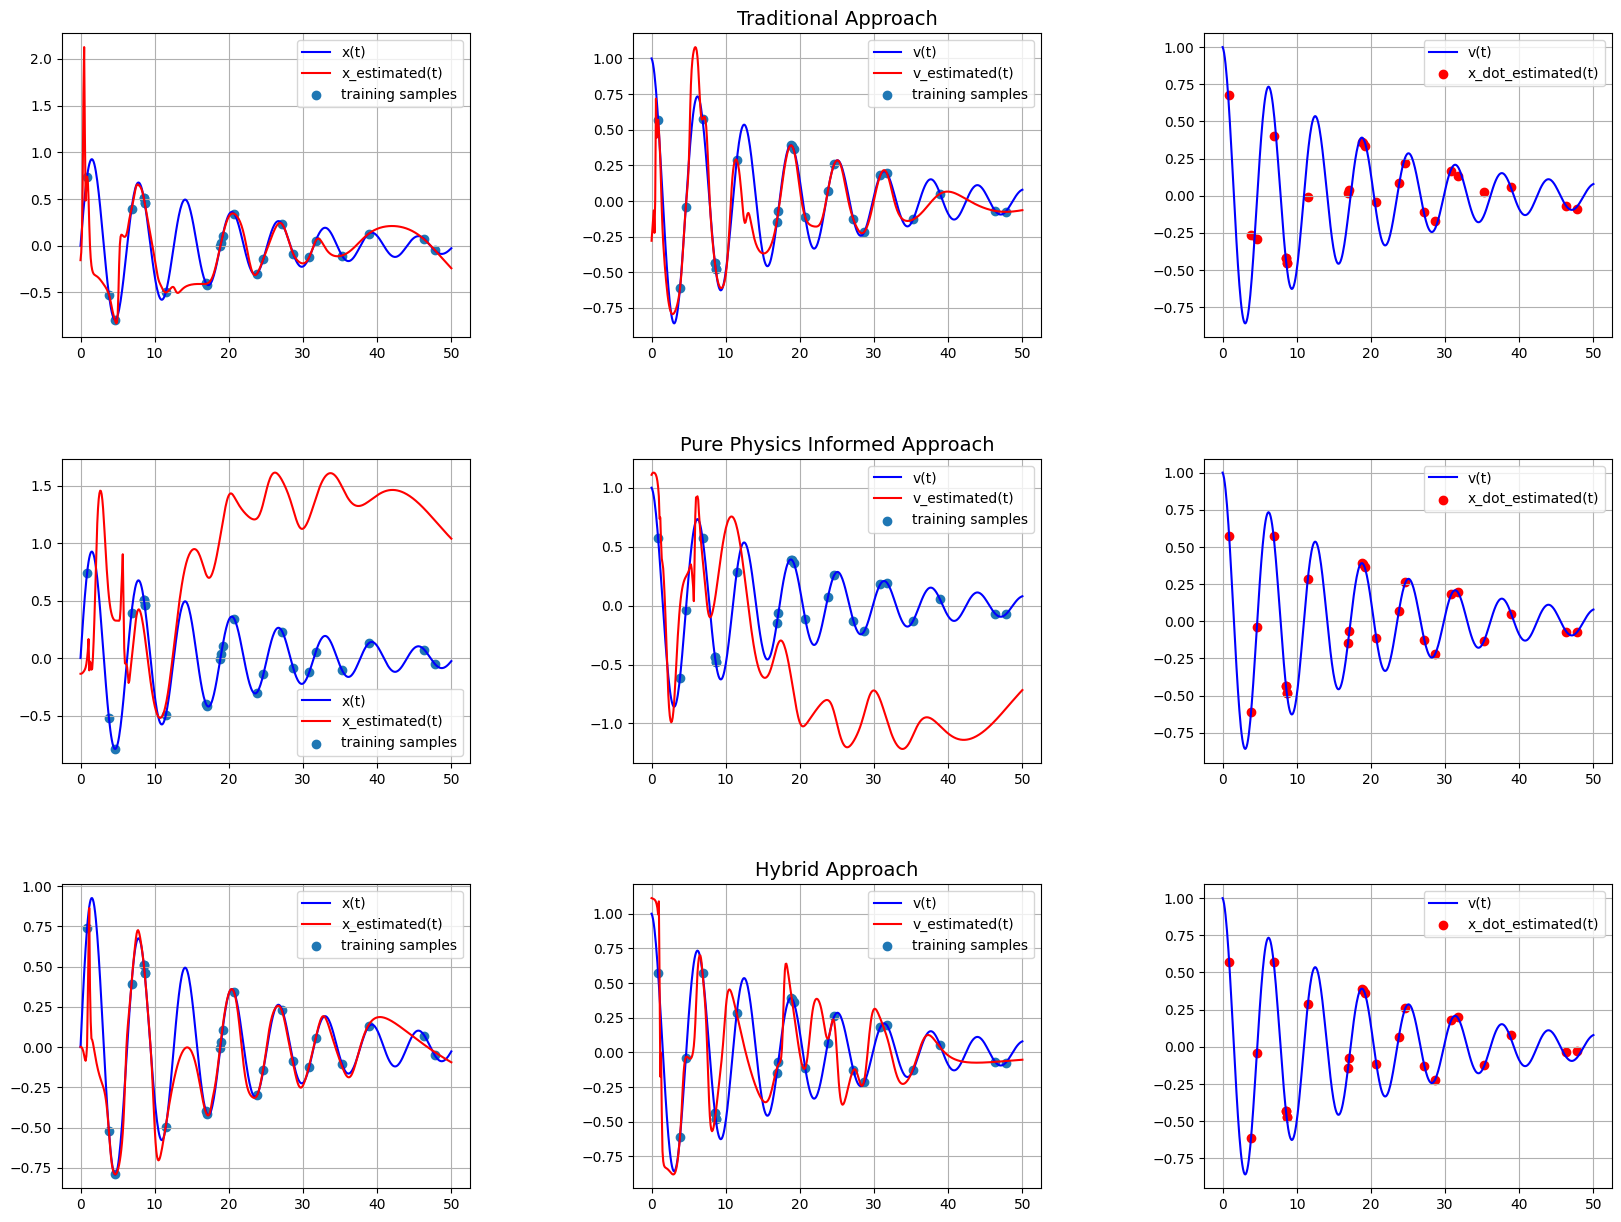

In [119]:
## Setup
# Create a 3x3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(20, 15))

fig.subplots_adjust(hspace=0.4, wspace=0.4)

axs[0, 1].set_title('Traditional Approach', fontsize=14)
axs[1, 1].set_title('Pure Physics Informed Approach', fontsize=14)
axs[2, 1].set_title('Hybrid Approach', fontsize=14)



## Test the classic network's ability to predict position and velocity
#
axs[0, 0].plot(t, sol[:, 0], color='b', label='x(t)')
axs[0, 0].plot(t, nn_sol[:,0], color='red', label='x_estimated(t)')
axs[0, 0].scatter(t[indices], sol[indices,0], label='training samples')
axs[0, 0].legend(loc='best')
axs[0, 0].grid()



#
axs[0, 1].plot(t, sol[:, 1], 'b', label='v(t)')
axs[0, 1].plot(t, nn_sol[:,1], 'red', label='v_estimated(t)')
axs[0, 1].scatter(t[indices], sol[indices,1], label='training samples')
axs[0, 1].legend(loc='best')
axs[0, 1].grid()


## Test the pure PINN's ability to predict position and velocity
#
axs[1, 0].plot(t, sol[:, 0], 'b', label='x(t)')
axs[1, 0].plot(t, nn_sol_pinn[:,0], 'red', label='x_estimated(t)')
axs[1, 0].scatter(t[indices], sol[indices,0], label='training samples')
axs[1, 0].legend(loc='best')
axs[1, 0].grid()


#
axs[1, 1].plot(t, sol[:, 1], 'b', label='v(t)')
axs[1, 1].plot(t, nn_sol_pinn[:,1], 'red', label='v_estimated(t)')
axs[1, 1].scatter(t[indices], sol[indices,1], label='training samples')
axs[1, 1].legend(loc='best')
axs[1, 1].grid()


## Test the hybrid PINN's ability to predict position and velocity
#
axs[2, 0].plot(t, sol[:, 0], 'b', label='x(t)')
axs[2, 0].plot(t, nn_sol_hyb[:,0], 'red', label='x_estimated(t)')
axs[2, 0].scatter(t[indices], sol[indices,0], label='training samples')
axs[2, 0].legend(loc='best')
axs[2, 0].grid()


#
axs[2, 1].plot(t, sol[:, 1], 'b', label='v(t)')
axs[2, 1].plot(t, nn_sol_hyb[:,1], 'red', label='v_estimated(t)')
axs[2, 1].scatter(t[indices], sol[indices,1], label='training samples')
axs[2, 1].legend(loc='best')
axs[2, 1].grid()


## Test Differential condition for all networks
#
axs[0, 2].plot(t[0:510], sol[0:510, 1], 'b', label='v(t)')
axs[0, 2].scatter(data.cpu().detach().numpy()[:,0], nn_grads, color='red', label='x_dot_estimated(t)')
axs[0, 2].legend(loc='best')
axs[0, 2].grid()

#
axs[1, 2].plot(t[0:510], sol[0:510, 1], 'b', label='v(t)')
axs[1, 2].scatter(data.cpu().detach().numpy()[:,0], nn_grads_pinn, color='red', label='x_dot_estimated(t)')
axs[1, 2].legend(loc='best')
axs[1, 2].grid()

#
axs[2, 2].plot(t[0:510], sol[0:510, 1], 'b', label='v(t)')
axs[2, 2].scatter(data.cpu().detach().numpy()[:,0], nn_grads_hyb, color='red', label='x_dot_estimated(t)')
axs[2, 2].legend(loc='best')
axs[2, 2].grid()